#Packages

In [1]:
!pip install linearmodels pandas_datareader statsmodels

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant, graphics
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

%matplotlib inline

sns.set_style('whitegrid')

%matplotlib inline

from time import time
from pathlib import Path
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

from matplotlib.ticker import FuncFormatter


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%cd drive/MyDrive/ML_finance/jansen

/content/drive/MyDrive/ML_finance/jansen


# FAMA-Macbeth

In [ ]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2019-12')[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 120 entries, 2010-01 to 2019-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  120 non-null    float64
 1   SMB     120 non-null    float64
 2   HML     120 non-null    float64
 3   RMW     120 non-null    float64
 4   CMA     120 non-null    float64
 5   RF      120 non-null    float64
dtypes: float64(6)
memory usage: 6.6 KB


In [ ]:
ff_factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-3.36,0.34,0.43,-1.27,0.46,0.00
2010-02,3.40,1.51,3.23,-0.27,1.43,0.00
2010-03,6.31,1.85,2.21,-0.65,1.69,0.01
2010-04,2.00,4.98,2.89,0.69,1.72,0.01
2010-05,-7.89,0.04,-2.44,1.30,-0.22,0.01


In [ ]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,1.091000,-0.026250,-0.196083,0.115417,0.012583,0.042833
std,3.744453,2.305355,2.289326,1.492842,1.455950,0.065468
min,-9.570000,-4.580000,-4.770000,-3.880000,-3.240000,0.000000
25%,-0.917500,-1.792500,-1.850000,-0.700000,-1.010000,0.000000
50%,1.325000,0.255000,-0.380000,0.145000,0.005000,0.010000
75%,3.400000,1.427500,1.147500,1.010000,0.930000,0.062500
max,11.350000,7.040000,8.190000,3.480000,3.690000,0.210000


In [ ]:
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2019-12')[0]
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 120 entries, 2010-01 to 2019-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    120 non-null    float64
 1   Mines   120 non-null    float64
 2   Oil     120 non-null    float64
 3   Clths   120 non-null    float64
 4   Durbl   120 non-null    float64
 5   Chems   120 non-null    float64
 6   Cnsum   120 non-null    float64
 7   Cnstr   120 non-null    float64
 8   Steel   120 non-null    float64
 9   FabPr   120 non-null    float64
 10  Machn   120 non-null    float64
 11  Cars    120 non-null    float64
 12  Trans   120 non-null    float64
 13  Utils   120 non-null    float64
 14  Rtail   120 non-null    float64
 15  Finan   120 non-null    float64
 16  Other   120 non-null    float64
dtypes: float64(17)
memory usage: 16.9 KB


In [ ]:
ff_factor_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-3.36,0.34,0.43,-1.27,0.46,0.00
2010-02,3.40,1.51,3.23,-0.27,1.43,0.00
2010-03,6.31,1.85,2.21,-0.65,1.69,0.01
2010-04,2.00,4.98,2.89,0.69,1.72,0.01
2010-05,-7.89,0.04,-2.44,1.30,-0.22,0.01
...,...,...,...,...,...,...
2019-08,-2.58,-3.23,-4.77,0.55,-0.69,0.16
2019-09,1.43,0.27,6.74,1.84,3.36,0.18
2019-10,2.06,0.27,-1.92,0.44,-0.96,0.16


In [ ]:
DATA_STORE = Path('./data/assets.h5')

In [ ]:
with pd.HDFStore('./data/assets.h5') as store:
    prices = store['/quandl/wiki/prices'].adj_close.unstack().loc['2010':'2017']

In [ ]:
equities = pd.read_csv('./data/us_equities_meta_data.csv')
equities = equities.set_index('ticker')

In [ ]:
prices.columns

Index(['A', 'AA', 'AAL', 'AAMC', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT',
       ...
       'ZIOP', 'ZIXI', 'ZLC', 'ZLTQ', 'ZMH', 'ZNGA', 'ZOES', 'ZQK', 'ZTS',
       'ZUMZ'],
      dtype='object', name='ticker', length=3199)

In [ ]:
sectors = equities.filter(prices.columns, axis=0).sector.to_dict()

In [ ]:
prices = prices.filter(sectors.keys()).dropna(how='all', axis=1)

In [ ]:
returns = prices.resample('M').last().pct_change().mul(100).to_period('M')
returns = returns.dropna(how='all').dropna(axis=1)

In [ ]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1986 entries, A to ZUMZ
dtypes: float64(1986)
memory usage: 1.4 MB


In [ ]:
returns.describe()

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YRCW,YUM,ZAGG,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,...,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.598137,2.658056,1.544228,2.297691,1.296760,2.290171,1.209454,1.173323,1.599713,2.103545,...,0.117127,1.600593,4.007434,1.041136,1.815401,1.001863,1.502716,2.412964,1.355918,1.553843
std,7.462623,15.647878,9.828353,8.001594,7.735603,7.056411,12.011317,8.431578,6.145080,8.083600,...,35.608868,5.724676,18.631310,6.039191,8.533788,16.288426,9.291949,20.523482,9.772489,14.734098
min,-17.511250,-59.888203,-31.680975,-22.795414,-20.544662,-14.409396,-32.171964,-21.785201,-14.073315,-20.426829,...,-93.535620,-14.152071,-39.575531,-18.935548,-22.995447,-32.485190,-20.314509,-58.783784,-21.470588,-32.947233
25%,-2.967333,-6.248814,-3.656245,-2.436681,-3.513495,-2.115404,-6.369729,-3.489997,-1.635893,-3.582954,...,-16.569480,-2.091391,-6.491878,-3.359990,-3.370401,-9.690819,-3.722701,-9.907641,-4.949044,-8.236194
50%,0.965484,0.538329,1.892762,2.185527,1.382751,2.248978,0.710577,0.936159,1.707620,1.713062,...,-1.762821,1.115019,2.594340,0.943908,1.504713,-0.570125,1.405688,3.194888,0.271003,0.436840
75%,6.286010,8.956523,5.862709,6.706716,5.741240,7.093283,7.884065,6.597558,5.928253,6.774499,...,13.108901,4.874314,15.612824,4.670325,6.323002,9.532059,6.298286,12.663220,7.679014,9.925884
max,23.730070,66.469428,40.030441,34.412698,23.562515,18.831055,34.382995,27.906977,12.664582,23.553719,...,165.200000,14.877255,73.277662,14.660853,31.975099,61.473881,31.547619,76.528600,36.971831,45.381526


In [ ]:
returns.head()

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YRCW,YUM,ZAGG,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2010-02,12.236889,38.041431,7.757848,2.185527,3.422053,6.537959,22.934279,5.440199,3.163980,1.713062,...,-50.549451,-1.432330,29.702970,1.793327,9.463602,-0.220951,-2.212411,6.389776,2.659574,12.647290
2010-03,9.313414,0.272851,13.068473,7.509506,2.887175,14.847034,17.679681,7.089405,3.138374,-4.215479,...,17.777778,13.671412,8.015267,3.261816,3.605180,18.040492,17.799353,52.552553,19.689119,42.887029
2010-04,5.437627,-3.809524,3.646409,6.763926,7.585878,11.102128,4.184731,-4.771975,6.673582,23.255814,...,3.773585,11.228094,7.416961,2.888512,-1.858108,-2.664625,31.547619,16.535433,6.926407,-9.419229
2010-05,-10.755654,24.893918,-14.658849,2.194617,14.767184,-1.612471,-5.427899,-13.063628,1.658232,1.257862,...,-35.418182,-3.465347,-22.694825,-8.175997,-5.335628,-13.214885,-16.606132,-14.695946,-4.858300,-7.758621
2010-06,-12.144623,-2.491506,-14.363696,-4.808984,-2.938203,-2.082685,-9.125694,-4.797868,1.502558,-13.874292,...,-57.770270,-4.664225,22.127660,-3.361346,-7.745455,-16.654572,-9.937370,-37.029703,-3.829787,-5.899533


In [ ]:
ff_factor_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-3.36,0.34,0.43,-1.27,0.46,0.00
2010-02,3.40,1.51,3.23,-0.27,1.43,0.00
2010-03,6.31,1.85,2.21,-0.65,1.69,0.01
2010-04,2.00,4.98,2.89,0.69,1.72,0.01
2010-05,-7.89,0.04,-2.44,1.30,-0.22,0.01
...,...,...,...,...,...,...
2019-08,-2.58,-3.23,-4.77,0.55,-0.69,0.16
2019-09,1.43,0.27,6.74,1.84,3.36,0.18
2019-10,2.06,0.27,-1.92,0.44,-0.96,0.16


In [ ]:
ff_factor_data = ff_factor_data.loc[returns.index]
ff_portfolio_data = ff_portfolio_data.loc[returns.index]

In [ ]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.206000,0.056947,-0.054316,0.144737,0.043368,0.012737
std,3.568382,2.312400,2.214041,1.583725,1.419882,0.022665
min,-7.890000,-4.580000,-4.700000,-3.880000,-3.240000,0.000000
25%,-0.565000,-1.680000,-1.670000,-0.880000,-0.965000,0.000000
50%,1.290000,0.160000,-0.310000,0.270000,0.010000,0.000000
75%,3.265000,1.605000,1.220000,1.240000,0.940000,0.010000
max,11.350000,7.040000,8.190000,3.480000,3.690000,0.090000


In [ ]:
ff_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.079474,0.340737,0.654316,1.447053,1.200526,1.365368,1.204105,1.784105,0.690526,1.396105,1.307684,1.294526,1.501368,0.953158,1.260632,1.273053,1.355474
std,2.796924,7.829519,5.481207,5.025804,5.168799,5.592314,3.155156,5.249362,7.315336,4.697904,4.741435,5.747782,4.148468,3.201917,3.521364,4.858878,3.662468
min,-5.170000,-24.380000,-11.680000,-10.000000,-13.160000,-17.390000,-7.150000,-14.160000,-20.490000,-11.960000,-9.070000,-11.650000,-8.560000,-6.990000,-9.180000,-11.140000,-7.890000
25%,-0.680000,-5.625000,-3.010000,-1.550000,-1.940000,-1.240000,-0.860000,-2.375000,-4.340000,-1.270000,-1.735000,-1.260000,-0.780000,-0.655000,-0.900000,-1.485000,-0.975000
50%,0.960000,-0.350000,0.990000,1.240000,1.290000,1.440000,1.550000,2.200000,0.670000,1.490000,1.650000,0.670000,1.500000,1.260000,0.870000,1.960000,1.670000
75%,3.225000,5.745000,4.205000,3.905000,4.270000,4.475000,3.345000,5.575000,4.225000,3.855000,4.580000,4.815000,4.255000,2.970000,3.480000,4.100000,3.550000
max,6.670000,21.940000,15.940000,17.190000,16.610000,18.370000,8.260000,15.510000,21.350000,17.660000,14.750000,20.860000,12.980000,7.840000,12.440000,13.410000,10.770000


In [ ]:
excess_returns = returns.sub(ff_factor_data.RF, axis=0)
excess_returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1986 entries, A to ZUMZ
dtypes: float64(1986)
memory usage: 1.4 MB


In [ ]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

In [ ]:
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    95 non-null     float64
 1   Mines   95 non-null     float64
 2   Oil     95 non-null     float64
 3   Clths   95 non-null     float64
 4   Durbl   95 non-null     float64
 5   Chems   95 non-null     float64
 6   Cnsum   95 non-null     float64
 7   Cnstr   95 non-null     float64
 8   Steel   95 non-null     float64
 9   FabPr   95 non-null     float64
 10  Machn   95 non-null     float64
 11  Cars    95 non-null     float64
 12  Trans   95 non-null     float64
 13  Utils   95 non-null     float64
 14  Rtail   95 non-null     float64
 15  Finan   95 non-null     float64
 16  Other   95 non-null     float64
dtypes: float64(17)
memory usage: 13.4 KB


In [ ]:
ff_factor_data = ff_factor_data.drop('RF', axis=1)
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  95 non-null     float64
 1   SMB     95 non-null     float64
 2   HML     95 non-null     float64
 3   RMW     95 non-null     float64
 4   CMA     95 non-null     float64
dtypes: float64(5)
memory usage: 4.5 KB


In [ ]:
ff_factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-02,3.40,1.51,3.23,-0.27,1.43
2010-03,6.31,1.85,2.21,-0.65,1.69
2010-04,2.00,4.98,2.89,0.69,1.72
2010-05,-7.89,0.04,-2.44,1.30,-0.22
2010-06,-5.57,-2.47,-4.70,-0.16,-1.55


In [ ]:
ff_portfolio_data.head()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
date,,,,,,,,,,,,,,,,,
2010-02,1.86,12.38,2.26,6.70,9.94,5.79,1.38,5.90,4.20,7.32,7.31,6.52,5.98,-0.41,3.70,2.70,2.48
2010-03,5.05,7.23,3.21,11.13,5.55,7.50,3.26,5.54,12.03,5.29,7.75,8.87,8.99,3.12,6.46,8.16,6.43
2010-04,-1.29,-0.85,4.31,4.75,6.87,2.48,-1.97,10.86,-2.64,3.43,4.81,6.75,3.06,2.84,1.35,0.92,1.72
2010-05,-4.82,-7.96,-10.11,-5.99,-5.52,-10.57,-6.28,-8.09,-7.02,-9.00,-8.10,-6.89,-7.61,-6.30,-5.72,-9.22,-7.89
2010-06,-1.91,-7.09,-6.16,-9.69,-8.76,-7.97,-0.11,-14.16,-13.19,-6.38,-5.98,-7.69,-7.31,-0.70,-9.18,-7.37,-5.69


In [ ]:
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry],
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))

betas = pd.DataFrame(betas,
                     columns=ff_factor_data.columns,
                     index=ff_portfolio_data.columns)

betas.head()

,Mkt-RF,SMB,HML,RMW,CMA
Food,0.685206,-0.309058,-0.356319,0.307398,0.487738
Mines,1.308349,0.183393,0.222381,0.221504,0.537181
Oil,1.034263,0.170344,0.647723,0.003313,0.315890
Clths,0.966307,0.361005,-0.143524,0.620955,-0.031262
Durbl,1.178290,0.530581,0.067535,0.545414,-0.116301


In [ ]:
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index],
                exog=betas).fit()
    lambdas.append(step2.params)

lambdas = pd.DataFrame(lambdas,
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())
lambdas.head()

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-02,3.782825,5.172168,-0.973987,2.086636,-0.506548
2010-03,6.260254,-0.181305,-0.000494,2.643242,-1.527146
2010-04,1.824136,8.133189,-4.100088,-1.967232,-2.228364
2010-05,-7.726107,3.151571,-0.569618,1.322006,-0.041637
2010-06,-5.326121,-5.869757,-1.358489,-2.050018,0.084455


In [ ]:
lambdas

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-02,3.782825,5.172168,-0.973987,2.086636,-0.506548
2010-03,6.260254,-0.181305,-0.000494,2.643242,-1.527146
2010-04,1.824136,8.133189,-4.100088,-1.967232,-2.228364
2010-05,-7.726107,3.151571,-0.569618,1.322006,-0.041637
2010-06,-5.326121,-5.869757,-1.358489,-2.050018,0.084455
...,...,...,...,...,...
2017-08,0.388760,0.336509,-3.080917,-4.497459,0.460085
2017-09,3.050642,6.428413,1.275338,-4.285500,-0.337727
2017-10,2.401371,-2.356687,0.366016,1.654549,-3.828094


In [ ]:
ff_portfolio_data

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
date,,,,,,,,,,,,,,,,,
2010-02,1.86,12.38,2.26,6.70,9.94,5.79,1.38,5.90,4.20,7.32,7.31,6.52,5.98,-0.41,3.70,2.70,2.48
2010-03,5.05,7.23,3.21,11.13,5.55,7.50,3.26,5.54,12.03,5.29,7.75,8.87,8.99,3.12,6.46,8.16,6.43
2010-04,-1.29,-0.85,4.31,4.75,6.87,2.48,-1.97,10.86,-2.64,3.43,4.81,6.75,3.06,2.84,1.35,0.92,1.72
2010-05,-4.82,-7.96,-10.11,-5.99,-5.52,-10.57,-6.28,-8.09,-7.02,-9.00,-8.10,-6.89,-7.61,-6.30,-5.72,-9.22,-7.89
2010-06,-1.91,-7.09,-6.16,-9.69,-8.76,-7.97,-0.11,-14.16,-13.19,-6.38,-5.98,-7.69,-7.31,-0.70,-9.18,-7.37,-5.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08,-1.88,0.64,-5.22,-4.70,-3.69,1.49,0.55,-0.45,1.56,-1.53,1.27,0.67,1.50,2.11,-1.43,-1.31,1.68
2017-09,-0.28,-1.21,10.92,0.94,4.49,6.92,0.56,7.73,3.63,7.29,5.61,7.45,4.69,-2.06,0.65,5.13,0.18
2017-10,0.88,1.25,0.30,3.15,-1.65,4.70,-3.68,3.95,2.14,1.63,5.99,1.09,-0.39,2.98,3.89,3.30,2.47


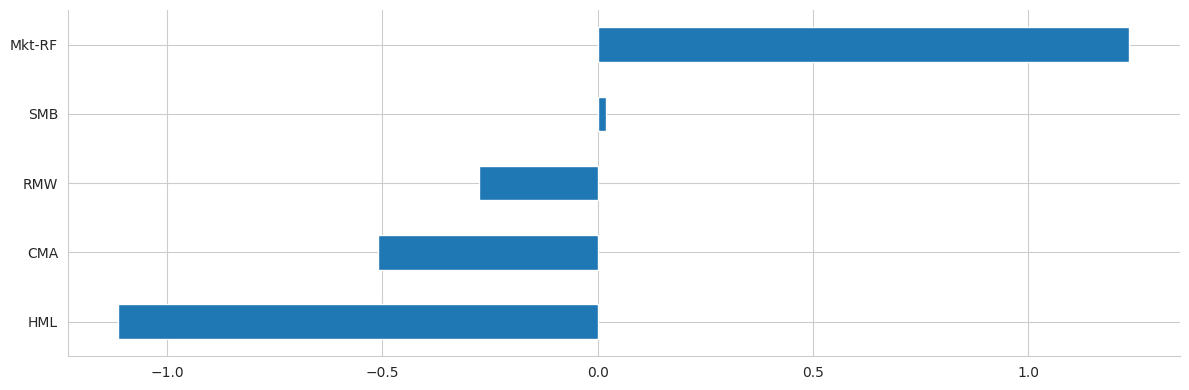

In [ ]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

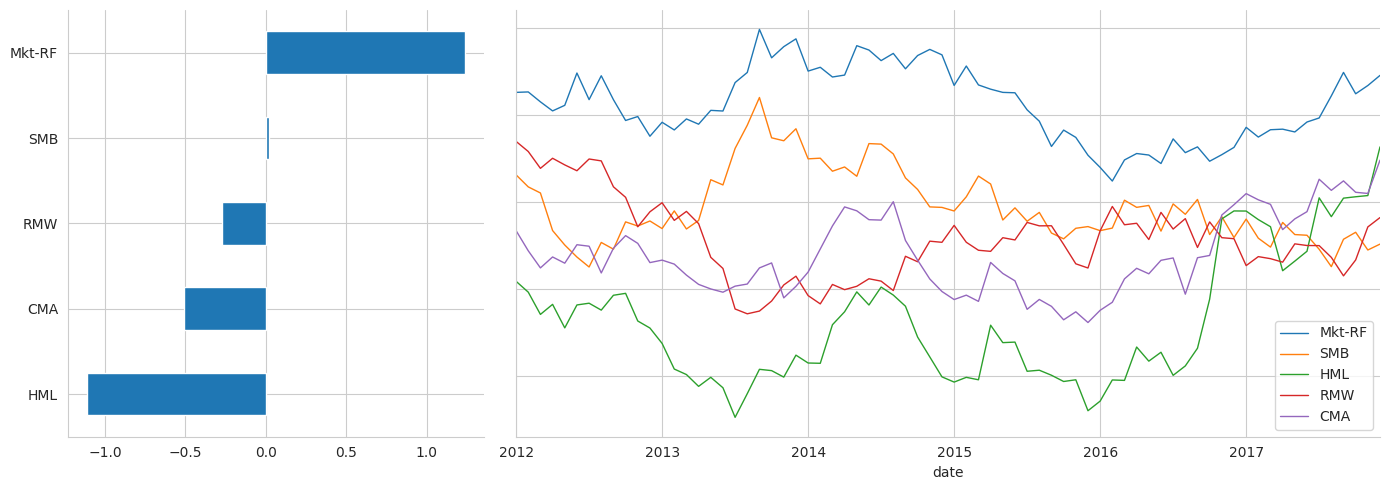

In [ ]:
window = 24  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1,
                                             figsize=(14, 5),
                                             sharey=True,
                                             ax=ax2)
sns.despine()
plt.tight_layout()

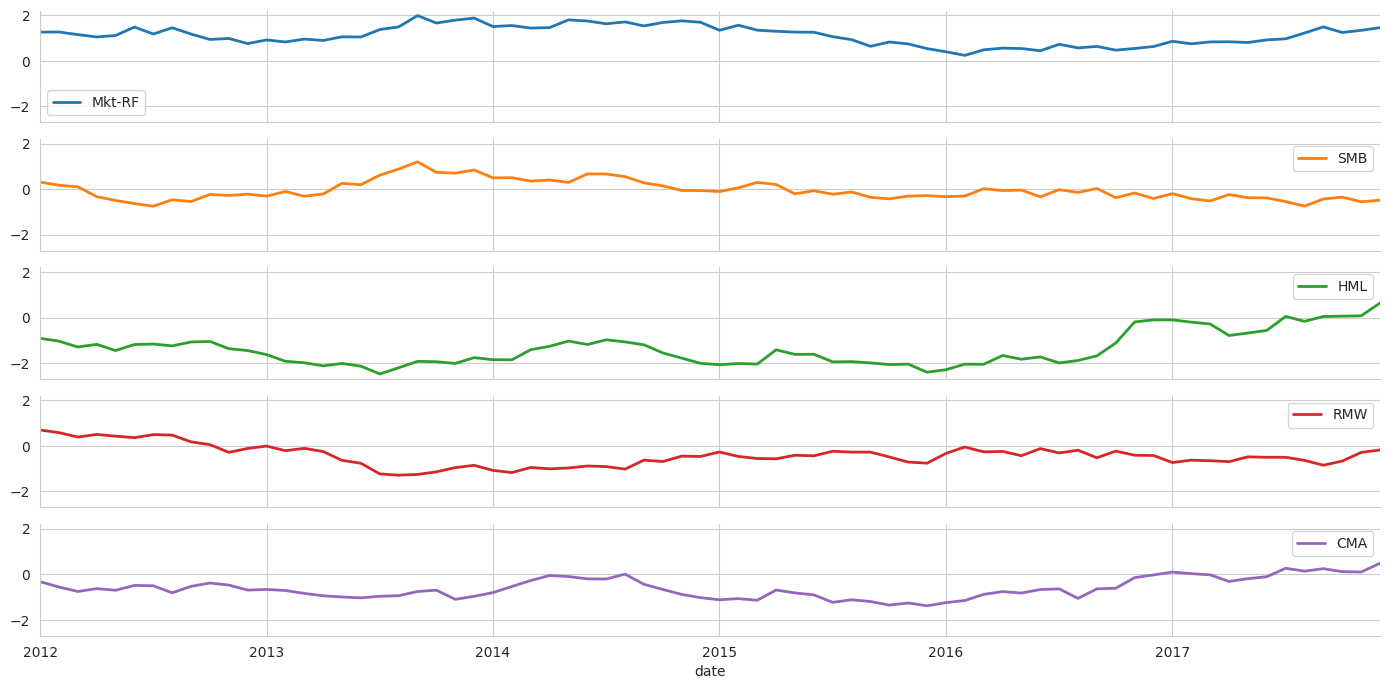

In [ ]:
window = 24  # months
lambdas.rolling(window).mean().dropna().plot(lw=2,
                                             figsize=(14, 7),
                                             subplots=True,
                                             sharey=True)
sns.despine()
plt.tight_layout()

In [ ]:
mod = LinearFactorModel(portfolios=ff_portfolio_data,
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6879
No. Factors:                          5   J-statistic:                    15.622
No. Observations:                    95   P-value                         0.2091
Date:                  Thu, Jun 22 2023   Distribution:                 chi2(12)
Time:                          20:28:44                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2357     0.4097     3.0158     0.0026      0.4326      2.0388
SMB            0.0202     0.8688    

In [ ]:
print(res.full_summary)


                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6879
No. Factors:                          5   J-statistic:                    15.622
No. Observations:                    95   P-value                         0.2091
Date:                  Thu, Jun 22 2023   Distribution:                 chi2(12)
Time:                          20:28:44                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2357     0.4097     3.0158     0.0026      0.4326      2.0388
SMB            0.0202     0.8688    

# Defining Features

In [1]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.6/272.6 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.26-cp310-cp310-linux_x86_64.whl size=2239087 sha256=35642053512b0b6612ed232d0c4

In [2]:
from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2013-01-01'
END = '2017-12-31'

In [8]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [9]:
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']


In [10]:
DATA_STORE = './data/assets.h5'

with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices'])

In [11]:
equities = pd.read_csv('./data/us_equities_meta_data.csv')
equities = equities.set_index('ticker')

In [12]:
prices = (prices.loc[idx[START:END,:],ohlcv]
 .rename(columns=lambda x: x.replace('adj_',''))
 .assign(volume=lambda x: x.volume.div(1000))
 .swaplevel()
 .sort_index())

In [13]:
equities = equities.loc[:,['marketcap', 'ipoyear', 'sector']]

In [14]:
# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker
nobs = prices.groupby(level='ticker').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]

In [15]:
equities.index.duplicated()

array([False, False, False, ..., False, False, False])

In [16]:
equities = equities[~equities.index.duplicated() & equities.sector.notnull()]
equities.sector = equities.sector.str.lower().str.replace(' ', '_')
equities.index.name = 'ticker'

In [17]:
shared = (prices.index.get_level_values('ticker').unique()
          .intersection(equities.index))

equities = equities.loc[shared, :]

prices = prices.loc[idx[shared, :], :]

In [18]:
prices.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2904233 non-null  float64
 1   close   2904233 non-null  float64
 2   low     2904233 non-null  float64
 3   high    2904233 non-null  float64
 4   volume  2904233 non-null  float64
dtypes: float64(5)
memory usage: 122.6+ MB


In [ ]:
with pd.HDFStore('./data/tmp.h5') as store:
     store.put('prices', prices)
     store.put('equities', equities)

In [19]:
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

In [20]:
prices['dollar_vol_1m'] = prices.dollar_vol.groupby('ticker').rolling(window=21).mean().values

In [21]:
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

In [ ]:
prices.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2904233 non-null  float64
 1   close            2904233 non-null  float64
 2   low              2904233 non-null  float64
 3   high             2904233 non-null  float64
 4   volume           2904233 non-null  float64
 5   dollar_vol       2904233 non-null  float64
 6   dollar_vol_1m    2857273 non-null  float64
 7   dollar_vol_rank  2857273 non-null  float64
dtypes: float64(8)
memory usage: 189.1+ MB


In [23]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

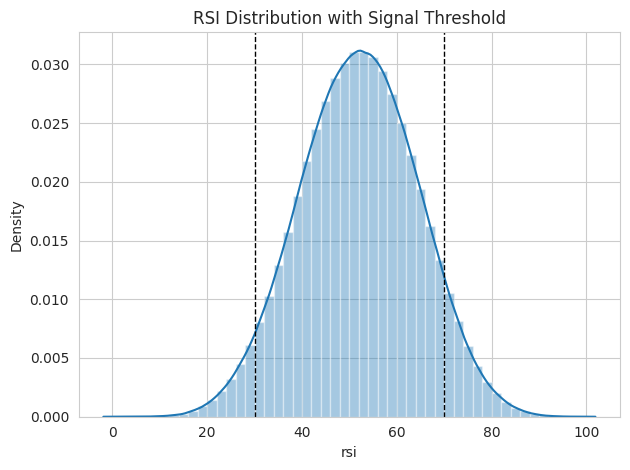

In [24]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

In [25]:

def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [26]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [27]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                     bb_high     bb_low  
ticker date                              
A      2013-01-02        NaN        NaN  
       2013-01-03        NaN        NaN  
       2013-01-04        NaN        NaN  
       2013-01-07        NaN        NaN  
       2013-01-08        NaN        NaN  
...                      ...        ...  
ZUMZ   2017-12-22  22.086859  19.503141  
       2017-12-26  22.073133  19.781867  
       2017-12-27  22.063697  19.896303  
       2017-12-28  22.083536  19.911464  
       2017-12-29  21.972038  19.925462  

[2904233 rows x 11 columns]

In [28]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

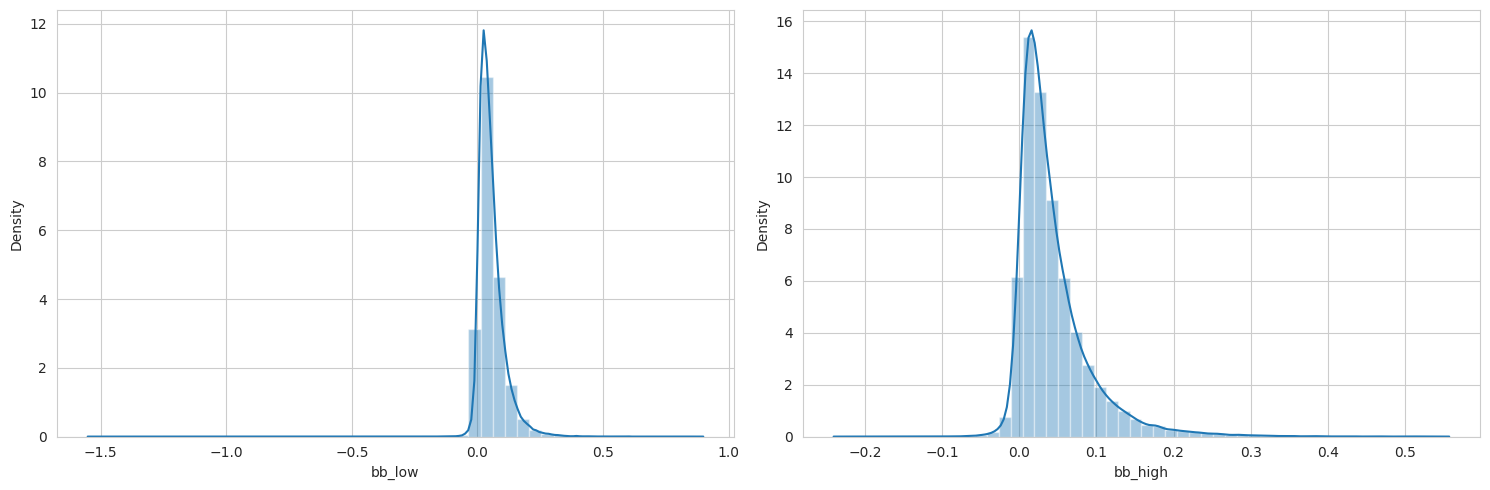

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

In [30]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low,
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [33]:
prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

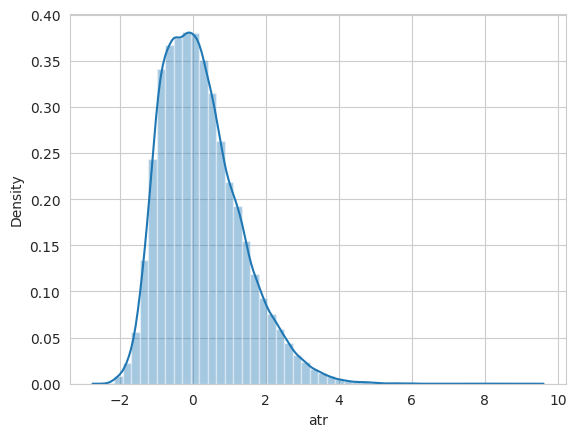

In [34]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());


In [35]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [36]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [39]:
(prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999])
.apply(lambda x: f'{x:,.1f}'))

count    2,826,749.0
mean             0.0
std              1.0
min            -10.5
0.1%            -4.1
1%              -2.6
2%              -2.2
3%              -2.0
4%              -1.8
5%              -1.6
50%              0.0
95%              1.6
96%              1.7
97%              1.9
98%              2.1
99%              2.6
99.9%            4.0
max              8.7
Name: macd, dtype: object

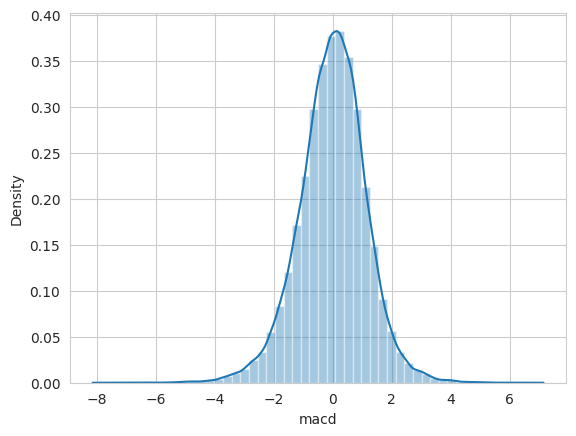

In [40]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());


In [42]:
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
(returns.describe(percentiles=percentiles).iloc[2:]
 .to_frame('percentiles').style.format(lambda x: f'{x:,.2%}'))

,percentiles
std,9.37%
min,-87.62%
0.01%,-33.40%
0.1%,-14.78%
1%,-6.52%
50%,0.04%
99%,6.98%
99.9%,17.03%
99.99%,39.25%
max,"10,280.40%"


In [43]:
lags = [1, 5, 10, 21, 42, 63]
q=0.0001
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

In [44]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

In [45]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

In [46]:
prices = prices.join(equities[['sector']])


In [47]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [48]:
prices.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 46 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2904233 non-null  float64
 1   close            2904233 non-null  float64
 2   low              2904233 non-null  float64
 3   high             2904233 non-null  float64
 4   volume           2904233 non-null  float64
 5   dollar_vol       2904233 non-null  float64
 6   dollar_vol_1m    2857273 non-null  float64
 7   dollar_vol_rank  2857273 non-null  float64
 8   rsi              2871361 non-null  float64
 9   bb_high          2859618 non-null  float64
 10  bb_low           2859585 non-null  float64
 11  atr              2871361 non-null  float64
 12  macd             2826749 non-null  float64
 13  return_1d        2901885 non-null  float64
 14  return_5d        2892493 non-null  float6

In [54]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('./data/data.h5', 'model_data/no_dummies')


In [52]:
pd.factorize(prices.sector, sort=True)

(array([1, 1, 1, ..., 4, 4, 4]),
 Index(['basic_industries', 'capital_goods', 'consumer_durables',
        'consumer_non-durables', 'consumer_services', 'energy', 'finance',
        'health_care', 'miscellaneous', 'public_utilities', 'technology',
        'transportation'],
       dtype='object'))

In [55]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [56]:
prices.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 69 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   open                   2904233 non-null  float64
 1   close                  2904233 non-null  float64
 2   low                    2904233 non-null  float64
 3   high                   2904233 non-null  float64
 4   volume                 2904233 non-null  float64
 5   dollar_vol             2904233 non-null  float64
 6   dollar_vol_1m          2857273 non-null  float64
 7   dollar_vol_rank        2857273 non-null  float64
 8   rsi                    2871361 non-null  float64
 9   bb_high                2859618 non-null  float64
 10  bb_low                 2859585 non-null  float64
 11  atr                    2871361 non-null  float64
 12  macd                   2826749 non-null  float64
 13 

In [57]:
prices.to_hdf('./data/data.h5', 'model_data')


In [58]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

In [59]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [61]:
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4209.0,0.001126,0.010457,-0.067138,-0.003606,0.001051,0.006156,0.061889
"(30, 70]",107244.0,0.000446,0.007711,-0.170571,-0.003054,0.000650,0.004246,0.075653
"(70, 100]",10634.0,0.000018,0.006354,-0.087857,-0.002818,0.000145,0.003121,0.058570


-2.68% (0.00%)


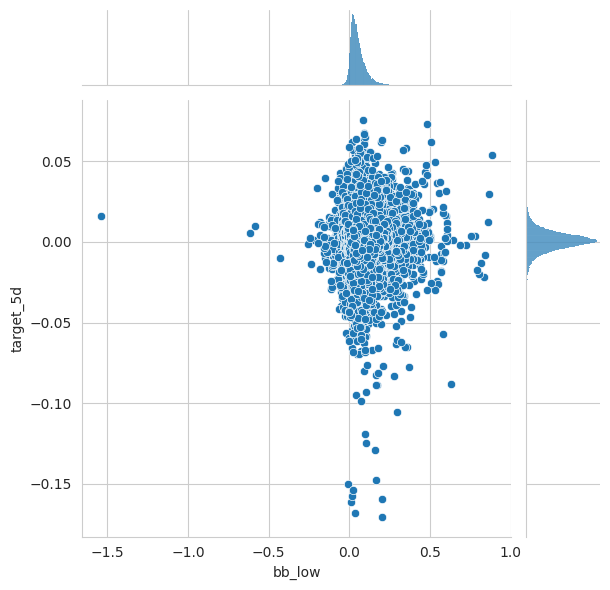

In [62]:
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

4.21% (0.00%)


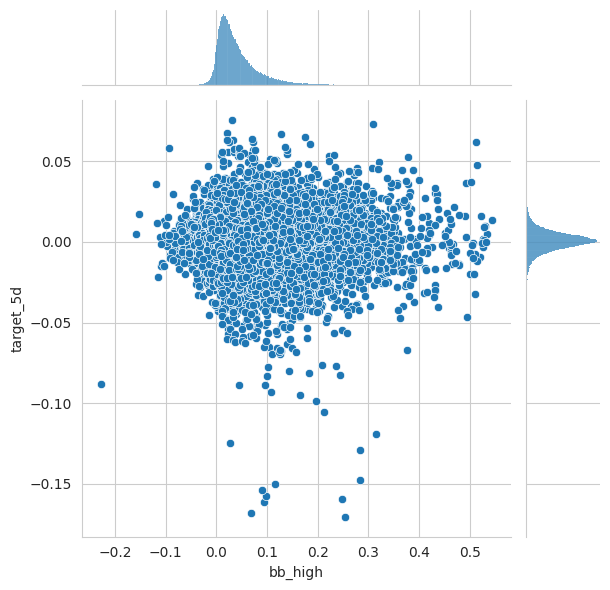

In [65]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

0.07% (80.08%)


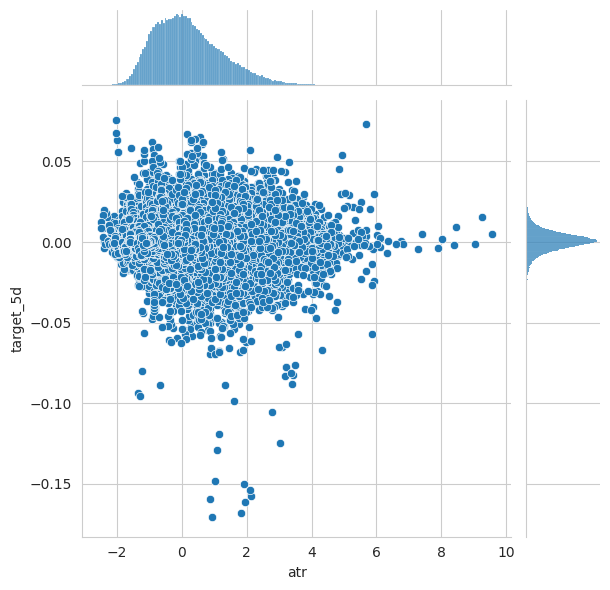

In [66]:
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

-4.72% (0.00%)


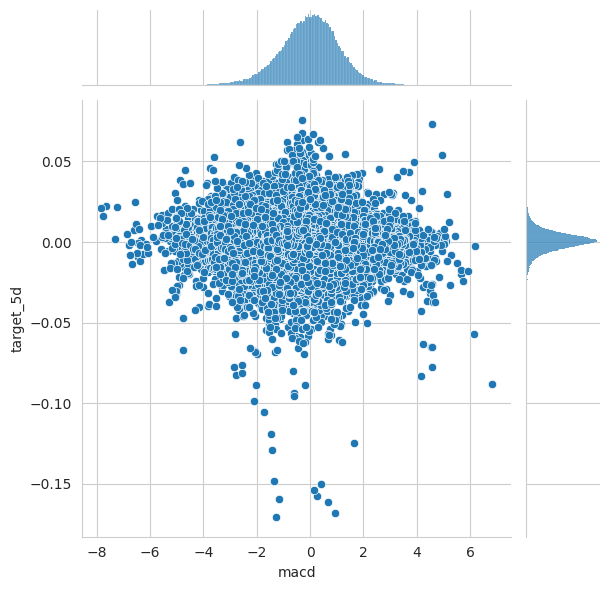

In [67]:
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

# Statistical Inference (OLS)

In [70]:
idx = pd.IndexSlice

In [72]:
with pd.HDFStore('./data/data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

In [73]:
data = data[data.dollar_vol_rank<100]


In [74]:

y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

In [76]:
y.columns

Index(['target_1d', 'target_5d', 'target_10d', 'target_21d'], dtype='object')

In [77]:
X.columns

Index(['dollar_vol_1m', 'rsi', 'bb_high', 'bb_low', 'atr', 'macd', 'return_1d',
       'return_5d', 'return_10d', 'return_21d', 'return_42d', 'return_63d',
       'return_1d_lag1', 'return_5d_lag1', 'return_10d_lag1',
       'return_21d_lag1', 'return_1d_lag2', 'return_5d_lag2',
       'return_10d_lag2', 'return_21d_lag2', 'return_1d_lag3',
       'return_5d_lag3', 'return_10d_lag3', 'return_21d_lag3',
       'return_1d_lag4', 'return_5d_lag4', 'return_10d_lag4',
       'return_21d_lag4', 'return_1d_lag5', 'return_5d_lag5',
       'return_10d_lag5', 'return_21d_lag5', 'year_2014', 'year_2015',
       'year_2016', 'year_2017', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'capital_goods', 'consumer_non-durables',
       'consumer_services', 'energy', 'finance', 'health_care',
       'miscellaneous', 'public_utilities', 'technology', 'transportation'],
      dtype='object')

In [78]:
s=pd.Series([1,2,3,4,5,10,11,12])

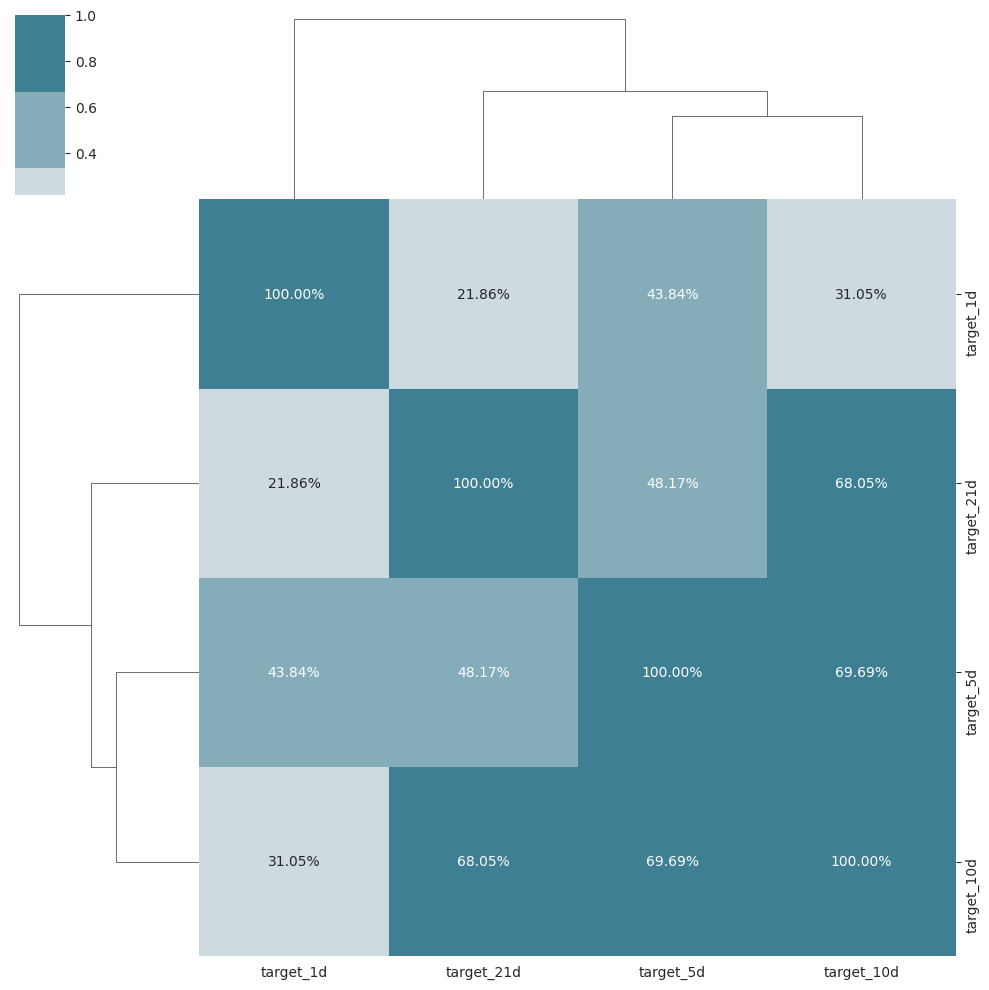

In [81]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');


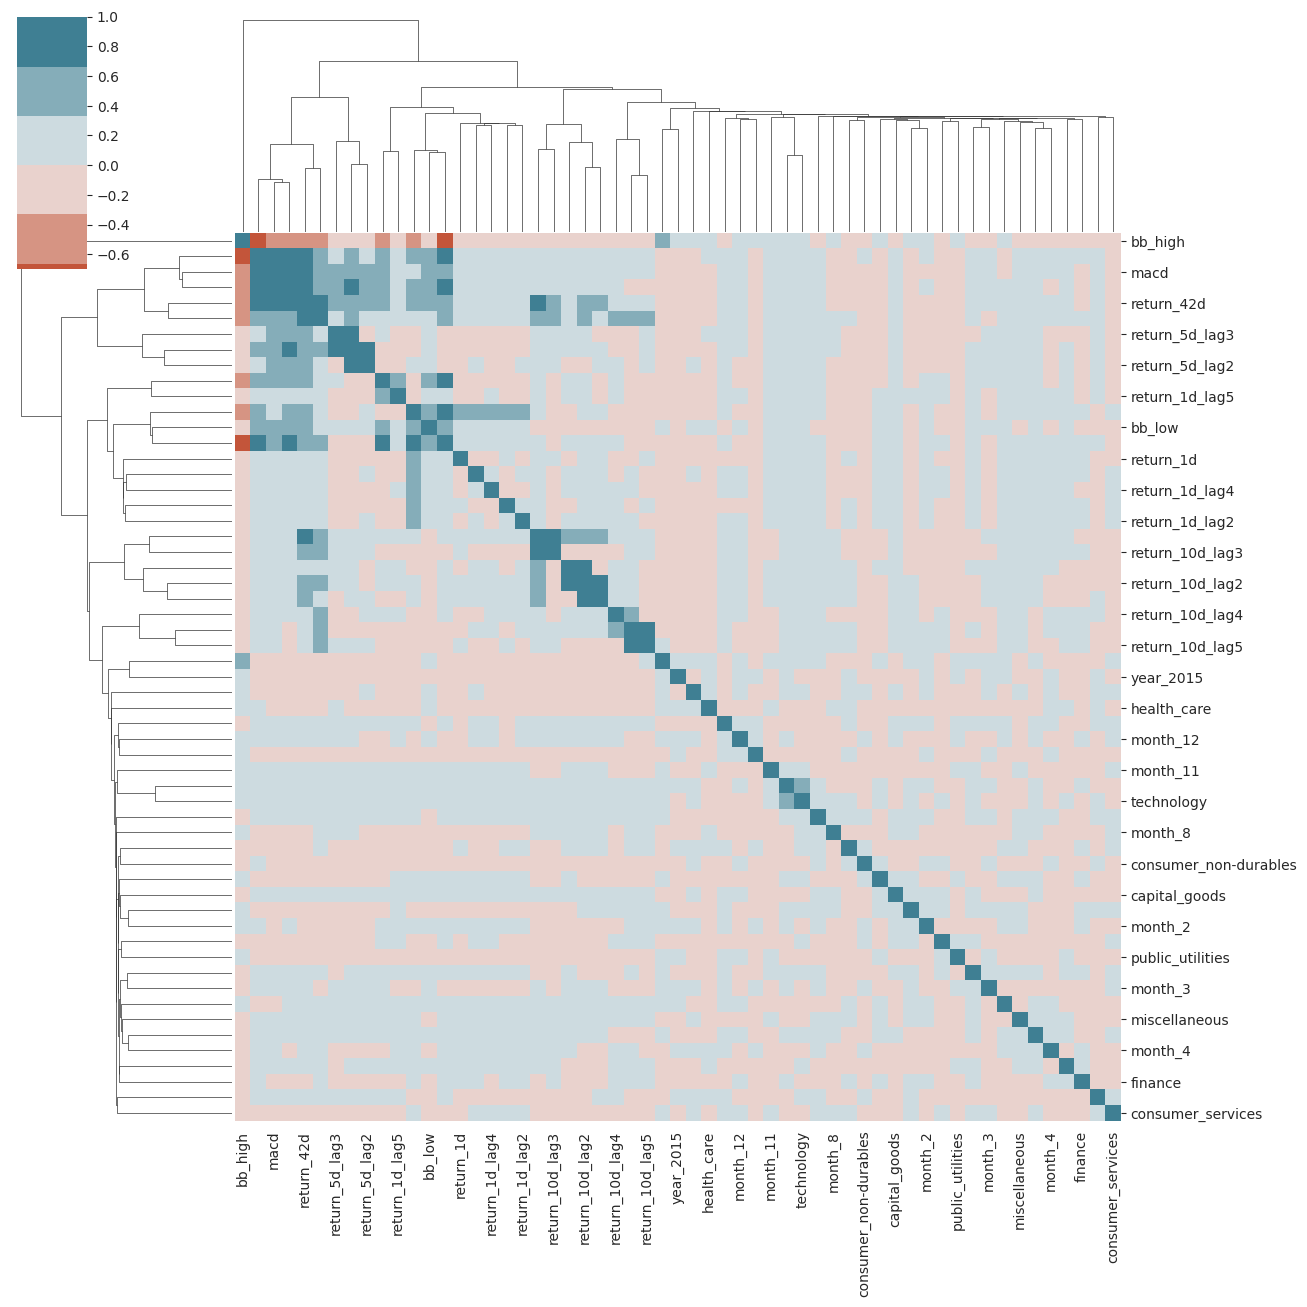

In [82]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

In [85]:
X.corr().head()

,dollar_vol_1m,rsi,bb_high,bb_low,atr,macd,return_1d,return_5d,return_10d,return_21d,...,capital_goods,consumer_non-durables,consumer_services,energy,finance,health_care,miscellaneous,public_utilities,technology,transportation
dollar_vol_1m,1.000000,0.030572,0.013085,0.043684,0.090698,0.000702,0.006626,0.011494,0.014060,0.019098,...,-0.038505,-0.092622,-0.013286,-0.066391,0.031697,-0.106351,-0.048175,-0.009616,0.332774,-0.087663
rsi,0.030572,1.000000,-0.696555,0.575231,-0.169038,0.817113,0.302014,0.594965,0.722691,0.759128,...,0.018249,0.005727,-0.008349,-0.066107,0.009357,-0.000603,0.033172,-0.030682,0.052029,-0.005444
bb_high,0.013085,-0.696555,1.000000,-0.093241,0.359661,-0.559794,-0.284125,-0.580094,-0.693640,-0.632777,...,-0.019439,-0.065282,-0.001110,0.051276,-0.040348,0.010218,-0.039201,0.003264,0.003468,0.030977
bb_low,0.043684,0.575231,-0.093241,1.000000,0.177661,0.425135,0.281458,0.547511,0.634893,0.524501,...,0.001376,-0.071540,-0.008024,-0.000968,-0.040538,0.001025,-0.020486,-0.028502,0.066794,0.035013
atr,0.090698,-0.169038,0.359661,0.177661,1.000000,-0.170858,-0.015376,-0.071725,-0.109513,-0.145273,...,-0.022416,-0.001486,0.018311,-0.002729,-0.041058,0.001594,-0.014514,0.015128,0.016295,0.008624


In [87]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)

In [88]:
corr_mat.head().append(corr_mat.tail())


,var1,var2,corr
581,return_42d,return_63d,0.835634
637,return_63d,return_42d,0.835634
286,macd,rsi,0.817113
62,rsi,macd,0.817113
518,return_21d,macd,0.793893
515,return_21d,bb_high,-0.632777
122,bb_high,return_10d,-0.693640
458,return_10d,bb_high,-0.693640
59,rsi,bb_high,-0.696555
115,bb_high,rsi,-0.696555


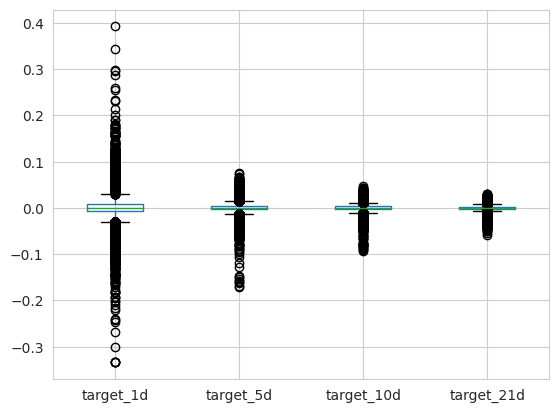

In [90]:
y.boxplot();


In [92]:
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
    .join(sectors)
    .fillna(0))

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     19.03
Date:                Fri, 23 Jun 2023   Prob (F-statistic):          9.43e-189
Time:                        17:26:25   Log-Likelihood:             2.8852e+05
No. Observations:              109675   AIC:                        -5.769e+05
Df Residuals:                  109617   BIC:                        -5.764e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

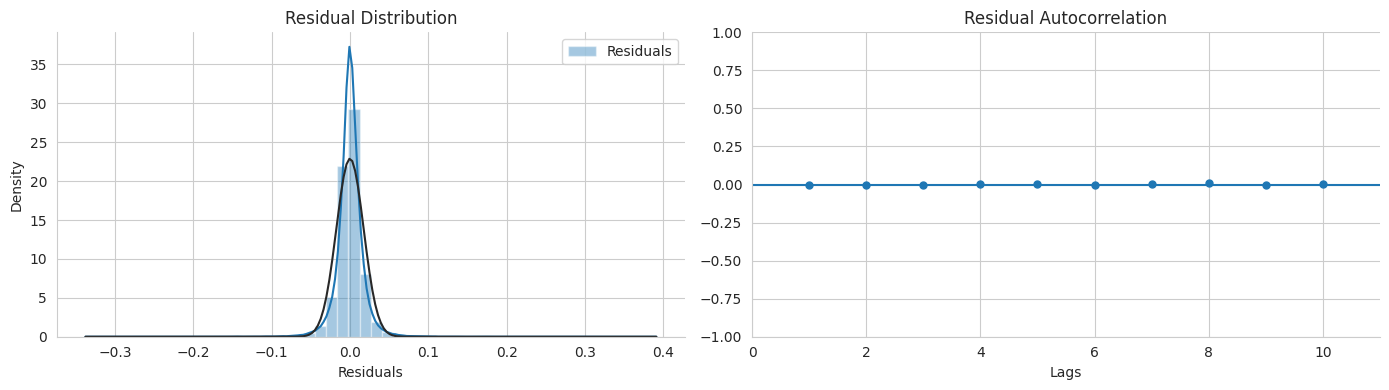

In [104]:
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     61.86
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:26:42   Log-Likelihood:             3.7883e+05
No. Observations:              109675   AIC:                        -7.575e+05
Df Residuals:                  109617   BIC:                        -7.570e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

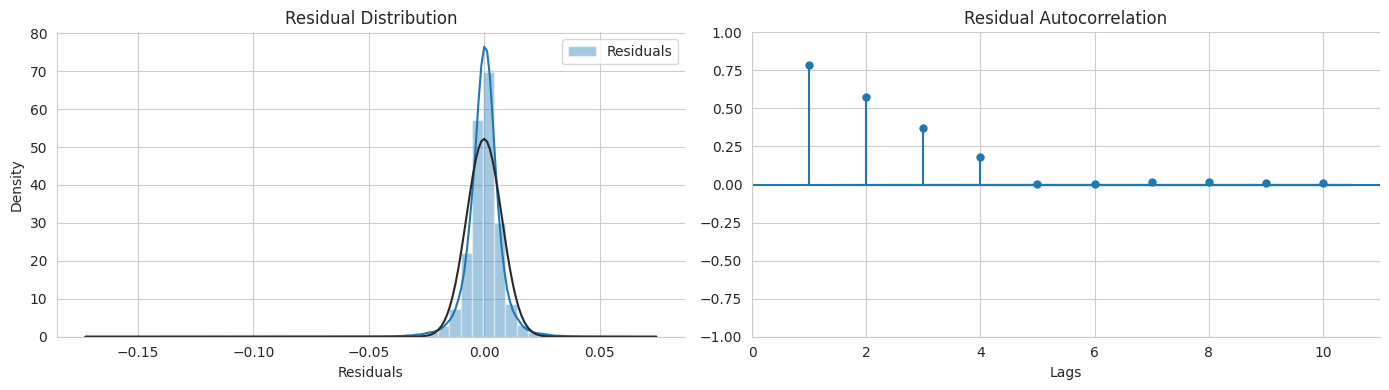

In [105]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     85.38
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:26:51   Log-Likelihood:             4.1892e+05
No. Observations:              109675   AIC:                        -8.377e+05
Df Residuals:                  109617   BIC:                        -8.372e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

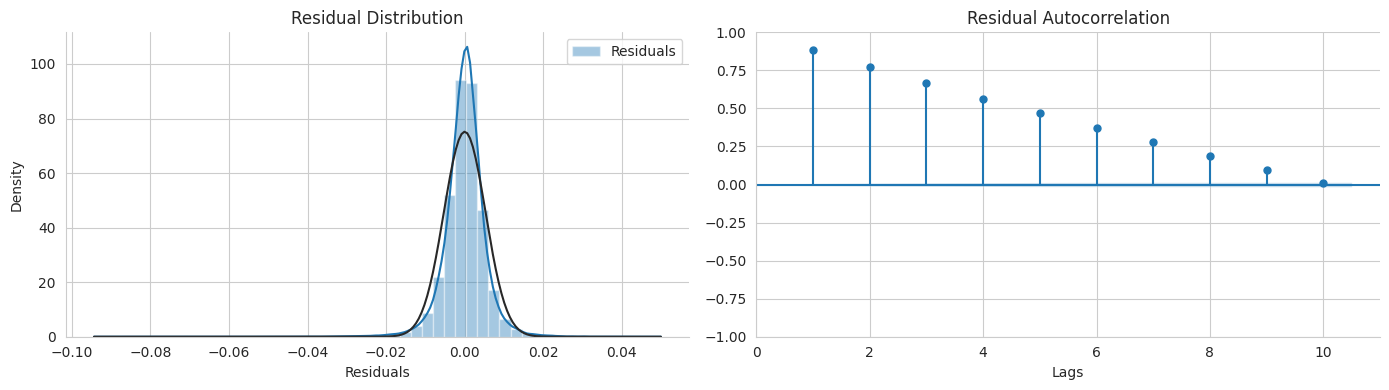

In [106]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     119.7
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:26:59   Log-Likelihood:             4.6155e+05
No. Observations:              109675   AIC:                        -9.230e+05
Df Residuals:                  109617   BIC:                        -9.224e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

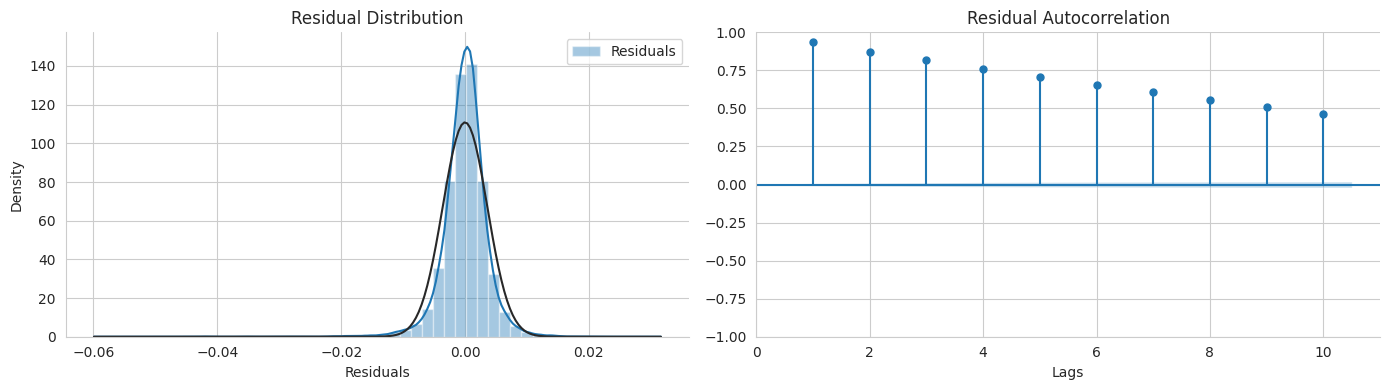

In [107]:
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

# Linear Regression with CV and IC

## Set-Up

In [3]:
idx = pd.IndexSlice
YEAR = 252

In [4]:
with pd.HDFStore('./data/data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

In [5]:
data.index.names = ['symbol', 'date']
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)

In [6]:
data = data[data.dollar_vol_rank<100]


In [7]:
data.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('AAL', Timestamp('2013-07-25 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109675 non-null  float64
 1   dollar_vol             109675 non-null  float64
 2   dollar_vol_1m          109675 non-null  float64
 3   dollar_vol_rank        109675 non-null  float64
 4   rsi                    109675 non-null  float64
 5   bb_high                109675 non-null  float64
 6   bb_low                 109675 non-null  float64
 7   atr                    109675 non-null  float64
 8   macd                   109675 non-null  float64
 9   return_1d              109675 non-null  float64
 10  return_5d              109675 non-null  float64
 11  return_10d             109675 non-null  float64
 12  return_21d             109675 non-null  float64
 13  return_42d    

In [8]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

In [9]:
data['consumer_durables']

symbol  date      
AAL     2013-07-25    0
        2013-07-26    0
        2013-07-29    0
        2013-07-30    0
        2013-07-31    0
                     ..
ZTS     2014-11-28    0
        2014-12-01    0
        2014-12-02    0
        2014-12-03    0
        2014-12-04    0
Name: consumer_durables, Length: 109675, dtype: uint8

In [10]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [11]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

63 2017-08-16 2017-11-14 10 2017-11-15 2017-11-29
63 2017-08-02 2017-10-30 10 2017-10-31 2017-11-14
63 2017-07-19 2017-10-16 10 2017-10-17 2017-10-30
63 2017-07-05 2017-10-02 10 2017-10-03 2017-10-16
63 2017-06-20 2017-09-18 10 2017-09-19 2017-10-02
63 2017-06-06 2017-09-01 10 2017-09-05 2017-09-18
63 2017-05-22 2017-08-18 10 2017-08-21 2017-09-01
63 2017-05-08 2017-08-04 10 2017-08-07 2017-08-18
63 2017-04-24 2017-07-21 10 2017-07-24 2017-08-04
62 2017-04-10 2017-07-07 10 2017-07-10 2017-07-21


In [12]:
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

In [13]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

In [14]:
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient \
                           (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error\
                              (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()

In [15]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

## Linear Regression

In [77]:
%%time
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):

    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

CPU times: user 6.38 s, sys: 7.22 s, total: 13.6 s
Wall time: 8.35 s


In [78]:
lr_scores.head()

,ic,rmse
date,,
2017-11-15,14.975550,0.019839
2017-11-16,-26.598103,0.011923
2017-11-17,38.779336,0.010337
2017-11-20,35.754771,0.012877
2017-11-21,-39.360786,0.009570


In [79]:
lr_predictions.head()

actuals  predicted
symbol date                           
AAPL   2017-11-15  0.011947  -0.001070
       2017-11-16 -0.005552  -0.000177
       2017-11-17 -0.000999  -0.000833
       2017-11-20  0.018590  -0.000467
       2017-11-21  0.010512   0.000103

In [80]:
lr_scores.to_hdf('./data/data.h5', 'lr/scores')
lr_predictions.to_hdf('./data/data.h5', 'lr/predictions')

In [81]:
lr_scores = pd.read_hdf('./data/data.h5', 'lr/scores')
lr_predictions = pd.read_hdf('./data/data.h5', 'lr/predictions')

In [82]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 1.531% (p-value: 0.0031%)


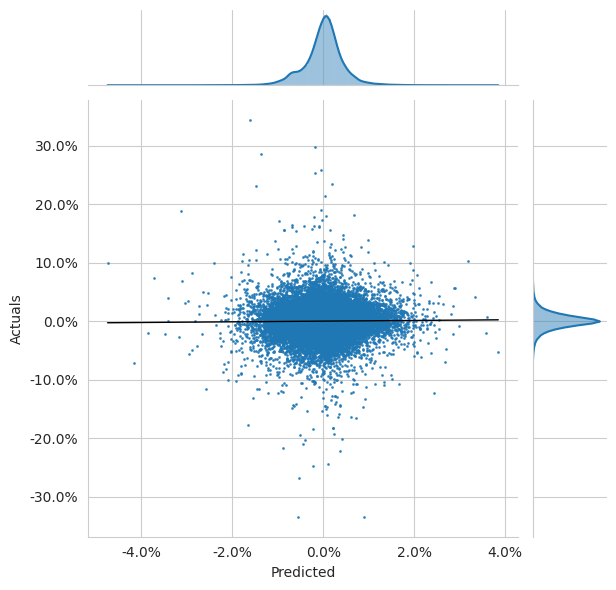

In [83]:
plot_preds_scatter(lr_predictions)


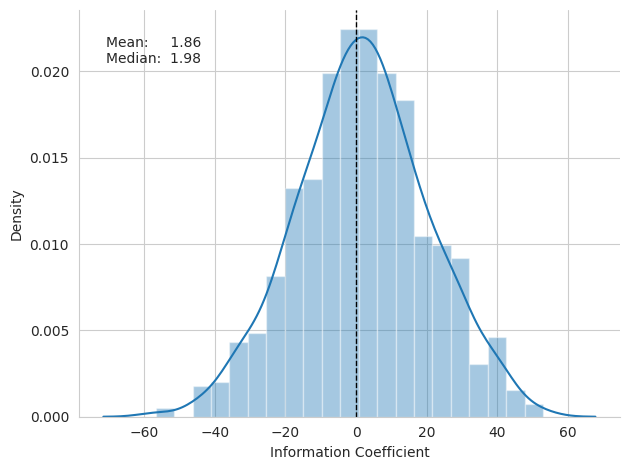

In [84]:
plot_ic_distribution(lr_scores)


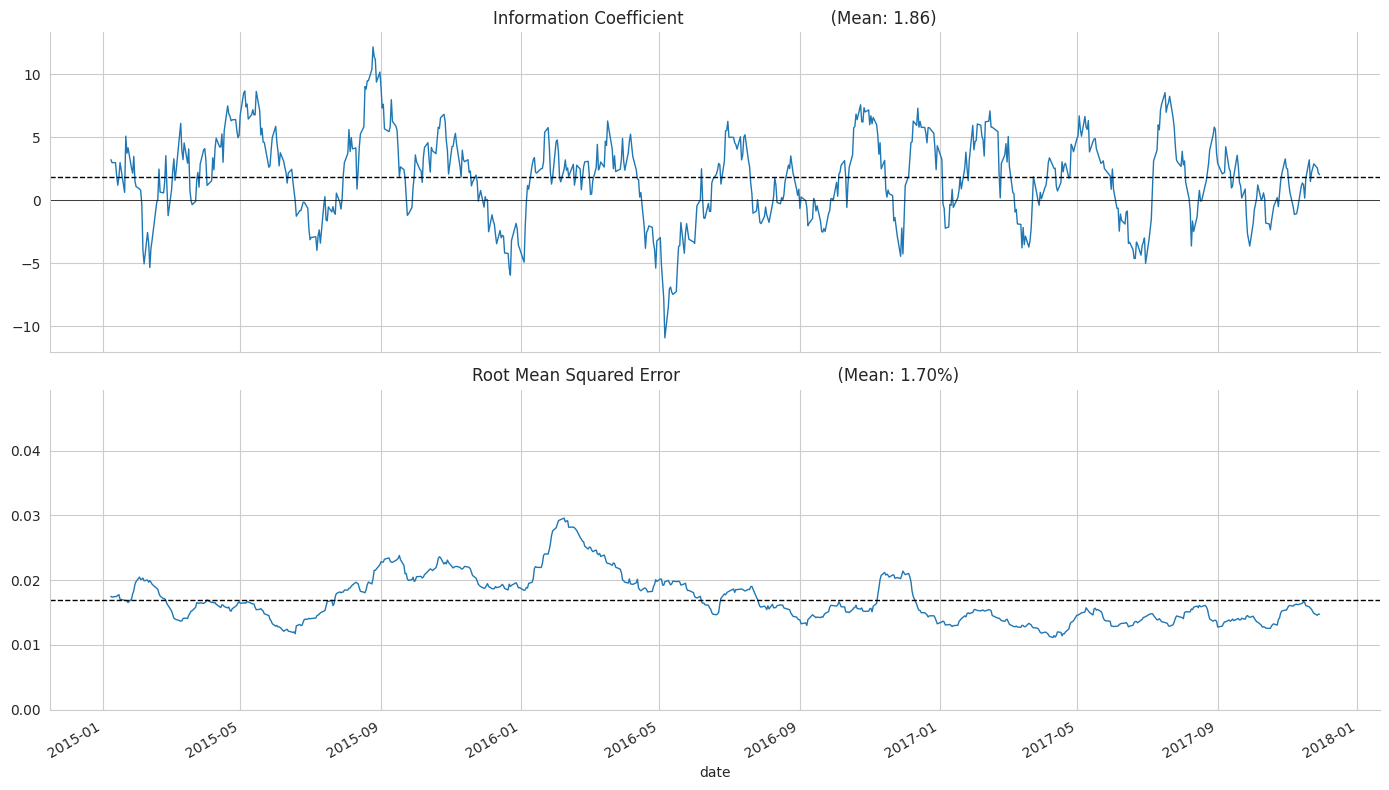

In [85]:
plot_rolling_ic(lr_scores)


## Ridge Regression

In [35]:
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [36]:
ridge_alphas

[0.0001,
 0.0005,
 0.001,
 0.005,
 0.01,
 0.05,
 0.1,
 0.5,
 1.0,
 5.0,
 10.0,
 50.0,
 100.0,
 500.0,
 1000.0,
 5000.0,
 10000.0,
 50000.0]

In [37]:
n_splits = int(3 * YEAR/test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

target = f'target_{lookahead}d'

X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [38]:
%%time
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

CPU times: user 1min 35s, sys: 1min 5s, total: 2min 41s
Wall time: 1min 49s


In [39]:
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf('./data/data.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('./data/data.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf('./data/data.h5', 'ridge/predictions')

In [40]:
ridge_scores = pd.read_hdf('./data/data.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf('./data/data.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf('./data/data.h5', 'ridge/predictions')

In [41]:
ridge_predictions.head()

actuals  predicted   alpha
symbol date                                   
AAPL   2017-11-15  0.011947  -0.001764  0.0001
       2017-11-16 -0.005552  -0.000870  0.0001
       2017-11-17 -0.000999  -0.001527  0.0001
       2017-11-20  0.018590  -0.001161  0.0001
       2017-11-21  0.010512  -0.000591  0.0001

In [42]:
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): 1.551% (p-value: 0.0000%)


In [43]:
ridge_scores.groupby('alpha').ic.describe()


,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0005,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0010,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0050,750.0,1.863890,18.565617,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0100,750.0,1.864012,18.565426,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0500,750.0,1.864657,18.566158,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.1000,750.0,1.864743,18.566752,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.5000,750.0,1.863531,18.566137,-56.835055,-9.996599,1.966605,14.124337,53.034014
1.0000,750.0,1.863910,18.566893,-56.835055,-9.996599,1.966605,14.110091,53.161410


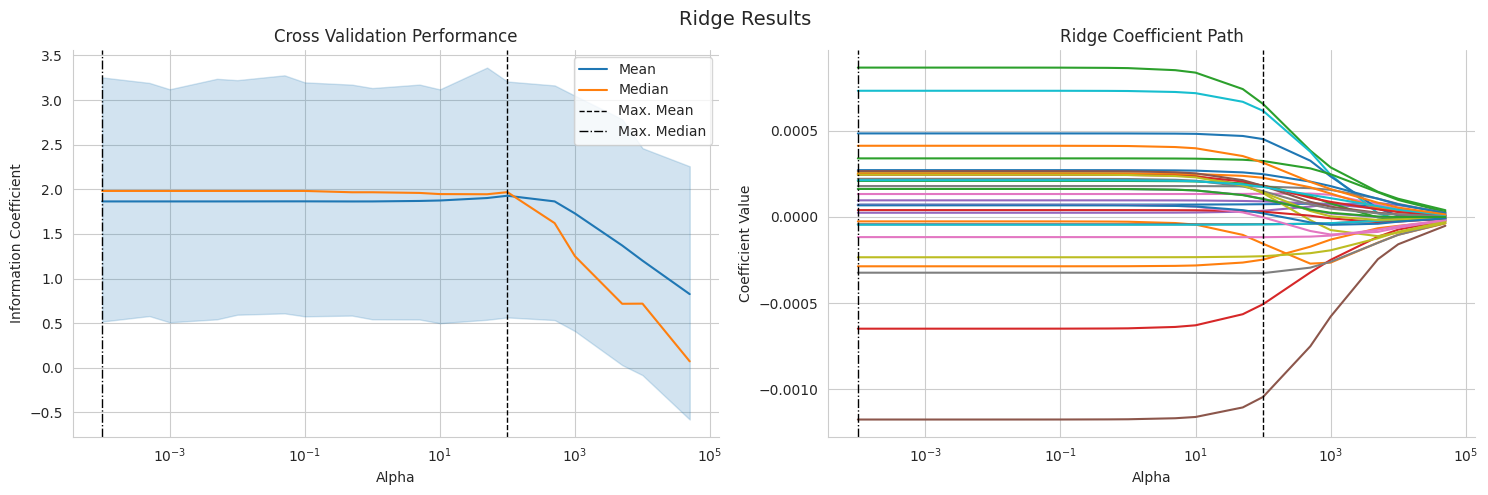

In [44]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')


fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

In [45]:
ridge_coeffs

,dollar_vol_1m,rsi,bb_high,bb_low,atr,macd,return_1d,return_5d,return_10d,return_21d,...,capital_goods,consumer_non-durables,consumer_services,energy,finance,health_care,miscellaneous,public_utilities,technology,transportation
0.0001,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.630176e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.632253e-04
0.0005,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.630173e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.632249e-04
0.0010,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.630168e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.632245e-04
0.0050,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.630133e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.632207e-04
0.0100,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.630088e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.632160e-04
0.0500,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.629729e-04,0.000267,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.631786e-04
0.1000,0.000072,-0.000026,0.000868,-0.000649,0.000025,-0.001177,0.000134,-0.000324,0.000255,0.000734,...,0.000245,1.629281e-04,0.000266,0.000071,0.000222,0.000246,0.000214,0.000068,0.000414,1.631319e-04
0.5000,0.000072,-0.000027,0.000867,-0.000648,0.000025,-0.001177,0.000134,-0.000324,0.000254,0.000733,...,0.000245,1.625708e-04,0.000266,0.000070,0.000221,0.000245,0.000213,0.000067,0.000413,1.627593e-04
1.0000,0.000072,-0.000028,0.000865,-0.000647,0.000025,-0.001176,0.000134,-0.000324,0.000253,0.000732,...,0.000244,1.621264e-04,0.000265,0.000070,0.000221,0.000244,0.000213,0.000067,0.000413,1.622959e-04
5.0000,0.000072,-0.000035,0.000853,-0.000639,0.000025,-0.001170,0.000134,-0.000324,0.000247,0.000727,...,0.000240,1.586609e-04,0.000260,0.000065,0.000216,0.000238,0.000211,0.000064,0.000407,1.586859e-04


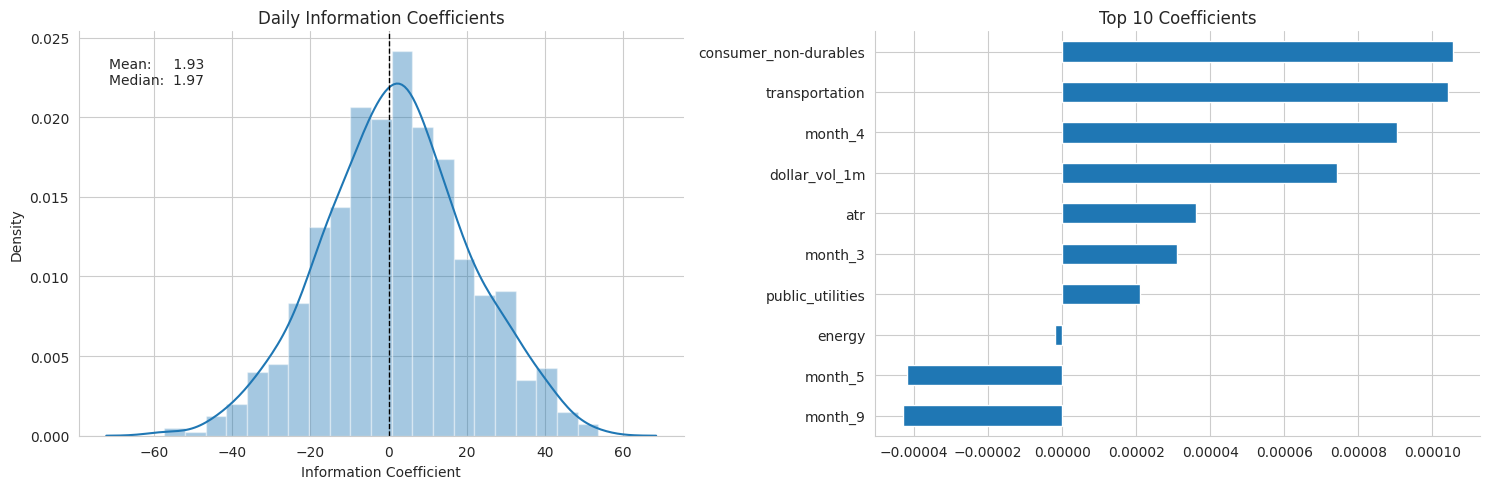

In [46]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

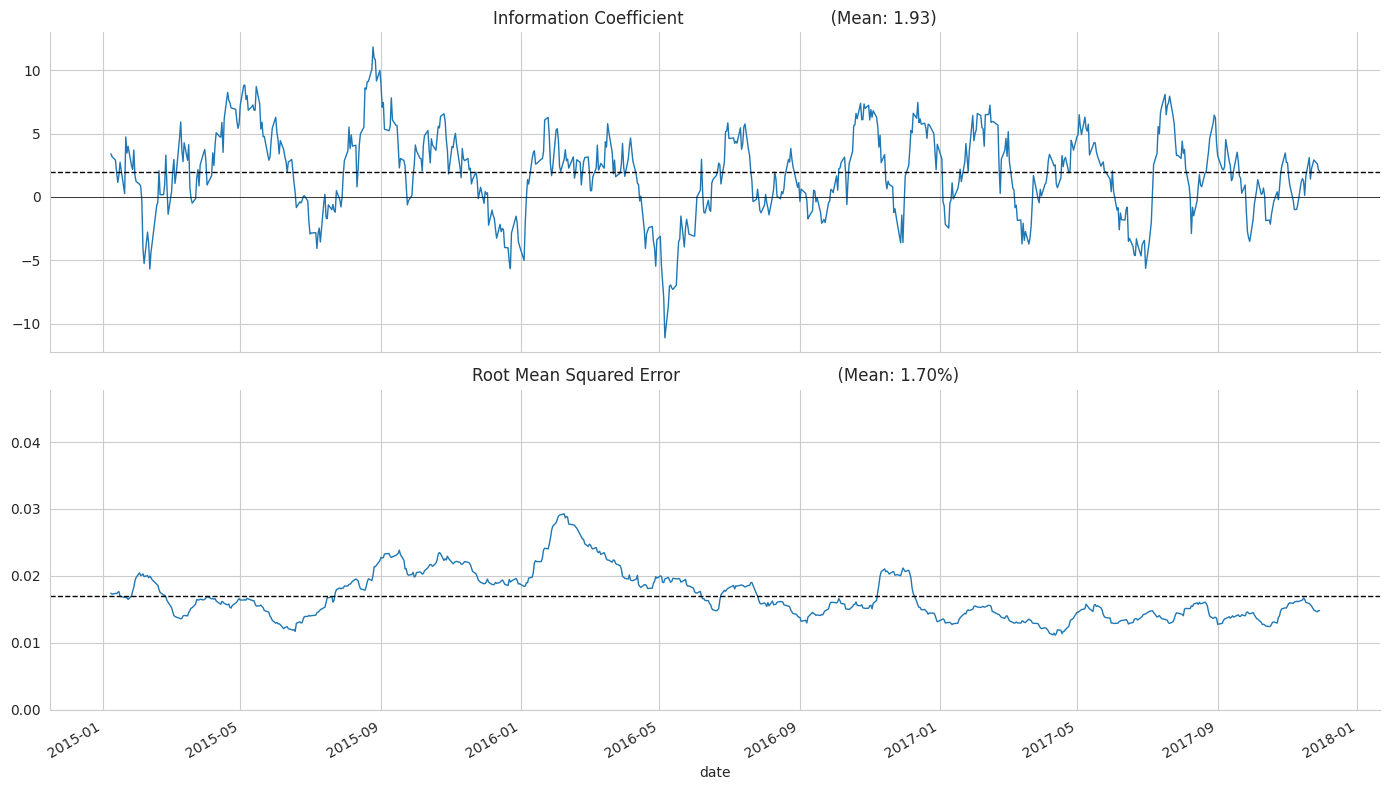

In [47]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

## Lasso

In [48]:
lasso_alphas = np.logspace(-10, -3, 8)
lasso_alphas

array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])

In [49]:
train_period_length = 63
test_period_length = 10
YEAR = 252
n_splits = int(3 * YEAR / test_period_length) # three years
lookahead = 1

In [50]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [51]:
target = f'target_{lookahead}d'

scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [52]:
%%time

lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')],
                           axis=1)

        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 CPU times: user 2min 10s, sys: 1min 45s, total: 3min 56s
Wall time: 2min 29s


In [53]:
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf('./data/data.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf('./data/data.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf('./data/data.h5', 'lasso/predictions')

In [54]:

best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 3.595% (p-value: 0.0000%)


In [55]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])


,mean,median
alpha,,
1.000000e-10,1.863889,1.981447
1.000000e-09,1.863758,1.981447
1.000000e-08,1.864487,1.981447
1.000000e-07,1.865393,1.966605
1.000000e-06,1.875294,1.962276
1.000000e-05,1.935876,2.191108
1.000000e-04,1.575376,1.012989
1.000000e-03,1.025462,1.768092


In [60]:
ridge_scores

,ic,rmse,alpha
date,,,
2017-11-15,14.975550,0.020270,0.0001
2017-11-16,-26.598103,0.011859,0.0001
2017-11-17,38.779336,0.010426,0.0001
2017-11-20,35.754771,0.013288,0.0001
2017-11-21,-39.360786,0.009613,0.0001
...,...,...,...
2014-12-16,-26.755720,0.031151,50000.0000
2014-12-17,21.856524,0.028092,50000.0000
2014-12-18,-49.324675,0.020744,50000.0000


In [59]:
lasso_scores

,ic,rmse,alpha
date,,,
2017-11-15,14.975550,0.020270,1.000000e-10
2017-11-16,-26.598103,0.011859,1.000000e-10
2017-11-17,38.779336,0.010426,1.000000e-10
2017-11-20,35.754771,0.013288,1.000000e-10
2017-11-21,-39.360786,0.009613,1.000000e-10
...,...,...,...
2014-12-16,-43.988592,0.031126,1.000000e-03
2014-12-17,17.595437,0.027943,1.000000e-03
2014-12-18,-62.958672,0.020994,1.000000e-03


In [70]:
lasso_scores['alpha'].unique()

array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])

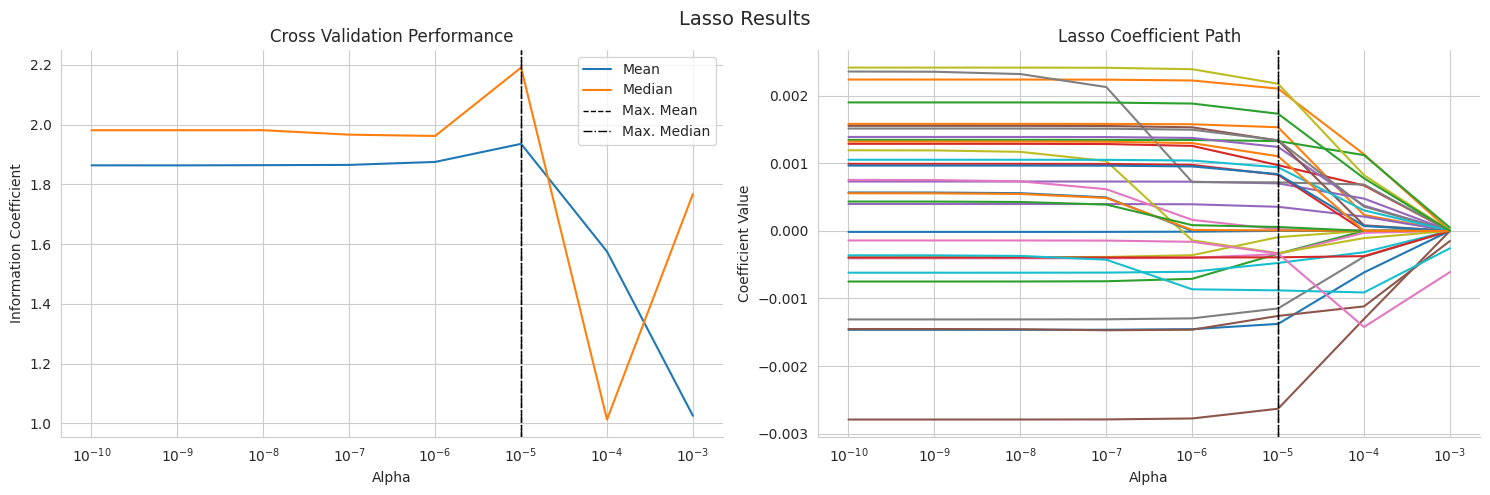

In [74]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(y=lasso_scores.groupby('alpha')['ic'].mean().values,
                  x=lasso_scores['alpha'].unique(),
                  label='Mean',
                  ax=axes[0])


scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine();

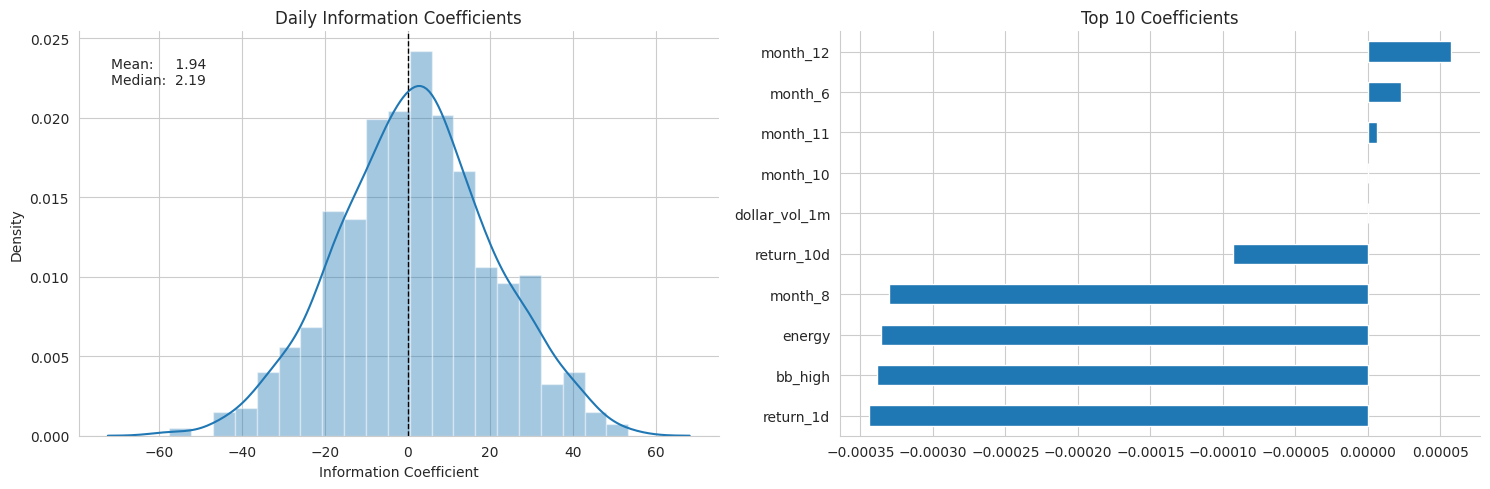

In [75]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

In [86]:
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]


best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

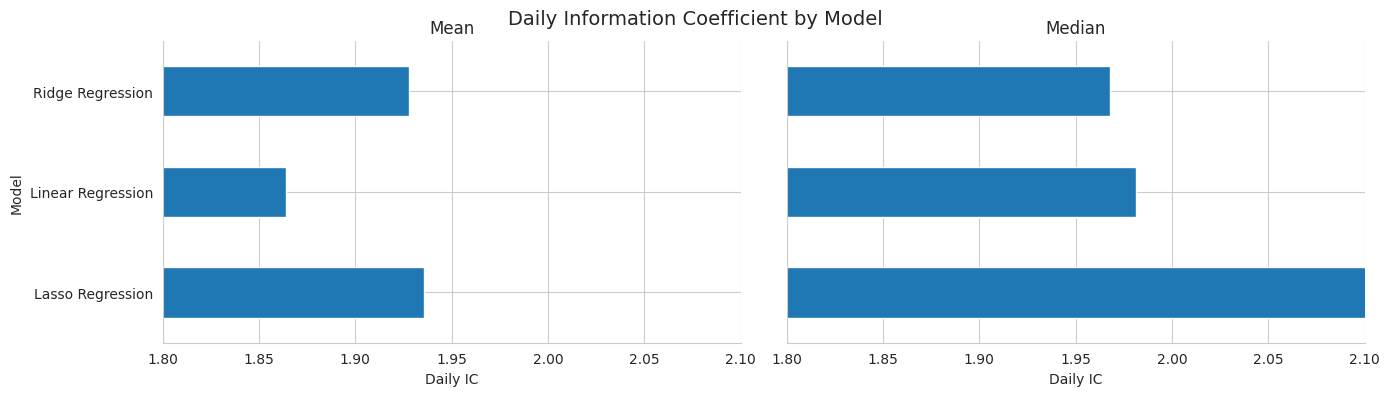

In [87]:
scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(1.85, 2), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(1.8, 2.1), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

# Logistic Regression with Macro Data

In [120]:
import statsmodels.api as sm

In [121]:
data = pd.DataFrame(sm.datasets.macrodata.load().data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
dtypes: float64(14)
memory usage: 22.3 KB


In [123]:
data['growth_rate'] = data.realgdp.pct_change(4)
data['target'] = (data.growth_rate > data.growth_rate.rolling(20).mean()).astype(int).shift(-1)
data.quarter = data.quarter.astype(int)

In [125]:
data.target.value_counts()

0.0    112
1.0     90
Name: target, dtype: int64

In [127]:
data.tail()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,growth_rate,target
198,2008.0,3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33,0.000262,0.0
199,2008.0,4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91,-0.018619,0.0
200,2009.0,1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71,-0.033026,0.0
201,2009.0,2,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19,-0.038297,0.0
202,2009.0,3,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,1673.9,0.12,9.6,308.013,3.56,-3.44,-0.025086,NaN


In [128]:
pct_cols = ['realcons', 'realinv', 'realgovt', 'realdpi', 'm1']
drop_cols = ['year', 'realgdp', 'pop', 'cpi', 'growth_rate']
data.loc[:, pct_cols] = data.loc[:, pct_cols].pct_change(4)

In [129]:
data = pd.get_dummies(data.drop(drop_cols, axis=1), columns=['quarter'], drop_first=True).dropna()


In [131]:
data.head()


,realcons,realinv,realgovt,realdpi,m1,tbilrate,unemp,infl,realint,target,quarter_2,quarter_3,quarter_4
4,0.036957,0.156237,-0.016692,0.036356,-0.000716,3.50,5.2,2.31,1.19,0.0,0,0,0
5,0.034147,-0.040877,-0.043426,0.024170,-0.010586,2.68,5.2,0.14,2.55,0.0,1,0,0
6,0.019409,0.024718,-0.033758,0.026821,0.002847,2.36,5.6,2.70,-0.34,0.0,0,1,0
7,0.019673,-0.132257,-0.015738,0.018278,0.007857,2.29,6.3,1.21,1.08,0.0,0,0,1
8,0.009715,-0.196903,0.029544,0.014830,0.017908,2.37,6.8,-0.40,2.77,0.0,0,0,0


In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 4 to 201
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   realcons   198 non-null    float64
 1   realinv    198 non-null    float64
 2   realgovt   198 non-null    float64
 3   realdpi    198 non-null    float64
 4   m1         198 non-null    float64
 5   tbilrate   198 non-null    float64
 6   unemp      198 non-null    float64
 7   infl       198 non-null    float64
 8   realint    198 non-null    float64
 9   target     198 non-null    float64
 10  quarter_2  198 non-null    uint8  
 11  quarter_3  198 non-null    uint8  
 12  quarter_4  198 non-null    uint8  
dtypes: float64(10), uint8(3)
memory usage: 17.6 KB


In [133]:
model = sm.Logit(data.target, sm.add_constant(data.drop('target', axis=1)))
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.342965
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  198
Model:                          Logit   Df Residuals:                      185
Method:                           MLE   Df Model:                           12
Date:                Fri, 23 Jun 2023   Pseudo R-squ.:                  0.5022
Time:                        20:28:53   Log-Likelihood:                -67.907
converged:                       True   LL-Null:                       -136.42
Covariance Type:            nonrobust   LLR p-value:                 2.375e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.5881      1.908     -4.502      0.000     -12.327      -4.849
realcons     130.1446     26.633      4.887      0.000      77.945     182.344
realinv       18.8414      4.053      4.648      0.000      10.897      26.786
realgovt     -19.0318      6.010     -3.166      0.002     -30.812      -7.252
realdpi      -52.2473     19.912     -2.624      0.009     -91.275     -13.220
m1            -1.3462      6.177     -0.218      0.827     -13.453      10.761
tbilrate      60.8607     44.350      1.372      0.170     -26.063     147.784
unemp          0.9487      0.249      3.818      0.000       0.462       1.436
infl         -60.9647     44.362     -1.374      0.169    -147.913      25.984
realint      -61.0453     44.359     -1.376      0.169    -147.987      25.896
quarter_2      0.1128      0.618      0.182      0.855      -1.099       1.325
quarter_3     -0.1991      0.609     -0.327      0.744      -1.393       0.995
quarter_4      0.0007      0.608      0.001      0.999      -1.191       1.192
==============================================================================
"""

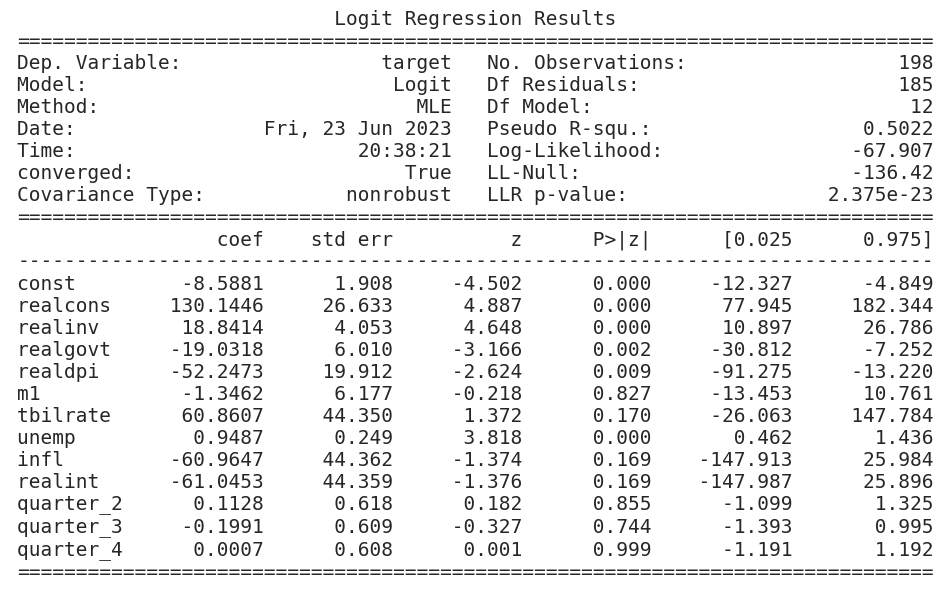

In [134]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(result.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('logistic_example.png', bbox_inches='tight', dpi=300);

# Predicting Price Movements

In [135]:
from pathlib import Path
import sys, os
from time import time

import pandas as pd
import numpy as np

from scipy.stats import spearmanr

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
idx = pd.IndexSlice
YEAR = 252

In [139]:

with pd.HDFStore('./data/data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))
data = data.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)

In [140]:
data = data[data.dollar_vol_rank<100]


In [141]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

In [143]:
train_period_length = 63
test_period_length = 10
lookahead =1
n_splits = int(3 * YEAR/test_period_length)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)
target = f'target_{lookahead}d'


y.loc[:, 'label'] = (y[target] > 0).astype(int)
y.label.value_counts()

1    56486
0    53189
Name: label, dtype: int64

In [145]:
Cs = np.logspace(-5, 5, 11)
cols = ['C', 'date', 'auc', 'ic', 'pval']

In [146]:
%%time
log_coeffs, log_scores, log_predictions = {}, [], []
for C in Cs:
    print(C)
    model = LogisticRegression(C=C,
                               fit_intercept=True,
                               random_state=42,
                               n_jobs=-1)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = aucs = 0
    start = time()
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        actuals = y[target].iloc[test_idx]
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
        y_score = pipe.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_score=y_score, y_true=y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        log_predictions.append(y_test.to_frame('labels').assign(
            predicted=y_score, C=C, actuals=actuals))
        date = y_test.index.get_level_values('date').min()
        log_scores.append([C, date, auc, ic * 100, pval])
        coeffs.append(pipe.named_steps['model'].coef_)
        ics += ic
        aucs += auc
        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')

    log_coeffs[C] = np.mean(coeffs, axis=0).squeeze()

1e-05
	 14.3 | 010 |  -0.31% |  50.42%
	 25.1 | 020 |   1.89% |  51.83%
	 35.8 | 030 |   2.84% |  52.01%
	 46.6 | 040 |   3.29% |  51.98%
	 57.5 | 050 |   3.97% |  52.44%
	 68.2 | 060 |   3.96% |  52.27%
	 78.9 | 070 |   4.73% |  52.59%
0.0001
	 10.7 | 010 |  -0.06% |  50.62%
	 21.3 | 020 |   2.23% |  52.01%
	 32.1 | 030 |   3.20% |  52.26%
	 42.9 | 040 |   3.34% |  52.08%
	 53.7 | 050 |   4.02% |  52.53%
	 64.3 | 060 |   4.02% |  52.33%
	 74.9 | 070 |   4.83% |  52.67%
0.001
	 10.8 | 010 |   0.42% |  50.96%
	 21.8 | 020 |   2.53% |  52.14%
	 32.6 | 030 |   3.58% |  52.48%
	 43.5 | 040 |   3.17% |  52.07%
	 54.2 | 050 |   3.83% |  52.49%
	 64.9 | 060 |   4.03% |  52.33%
	 75.7 | 070 |   4.88% |  52.70%
0.01
	 10.9 | 010 |   0.68% |  51.13%
	 21.7 | 020 |   2.39% |  51.97%
	 32.6 | 030 |   3.64% |  52.41%
	 43.4 | 040 |   3.12% |  51.94%
	 54.3 | 050 |   3.92% |  52.46%
	 65.3 | 060 |   4.16% |  52.30%
	 76.0 | 070 |   4.91% |  52.64%
0.1
	 11.0 | 010 |   0.65% |  51.11%
	 21.9 | 020 | 

In [147]:
log_scores = pd.DataFrame(log_scores, columns=cols)
log_scores.to_hdf('./data/data.h5', 'logistic/scores')

log_coeffs = pd.DataFrame(log_coeffs, index=X.columns).T
log_coeffs.to_hdf('./data/data.h5', 'logistic/coeffs')

log_predictions = pd.concat(log_predictions)
log_predictions.to_hdf('./data/data.h5', 'logistic/predictions')

In [149]:
print(log_scores.info())
log_scores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   C       825 non-null    float64       
 1   date    825 non-null    datetime64[ns]
 2   auc     825 non-null    float64       
 3   ic      825 non-null    float64       
 4   pval    825 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 32.4 KB
None


,C,date,auc,ic,pval
0,0.00001,2017-11-15,0.513699,-0.928056,0.771238
1,0.00001,2017-10-31,0.511148,0.424560,0.894239
2,0.00001,2017-10-17,0.468442,-4.093130,0.199767
3,0.00001,2017-10-03,0.507961,2.122769,0.504680
4,0.00001,2017-09-19,0.498571,-1.966844,0.536489


In [150]:
print(log_predictions.info())
log_predictions.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 814594 entries, ('AAPL', Timestamp('2017-11-15 00:00:00')) to ('XOM', Timestamp('2014-12-22 00:00:00'))
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   labels     814594 non-null  int64  
 1   predicted  814594 non-null  float64
 2   C          814594 non-null  float64
 3   actuals    814594 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 28.0+ MB
None


labels  predicted        C   actuals
ticker date                                            
AAPL   2017-11-15       1   0.533624  0.00001  0.011947
       2017-11-16       0   0.533972  0.00001 -0.005552
       2017-11-17       0   0.533759  0.00001 -0.000999
       2017-11-20       1   0.533854  0.00001  0.018590
       2017-11-21       1   0.534196  0.00001  0.010512

In [151]:
log_scores.groupby('C').auc.describe()


,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,75.0,0.524316,0.036131,0.432491,0.499719,0.519363,0.546030,0.625816
0.00010,75.0,0.525045,0.035658,0.442738,0.501438,0.520094,0.546003,0.635535
0.00100,75.0,0.525448,0.036371,0.438676,0.500371,0.520211,0.545218,0.641011
0.01000,75.0,0.525076,0.036905,0.435870,0.500481,0.522237,0.550842,0.641632
0.10000,75.0,0.523552,0.036496,0.427256,0.499836,0.523206,0.549261,0.621749
1.00000,75.0,0.523159,0.036445,0.424981,0.498530,0.521782,0.549033,0.616444
10.00000,75.0,0.523109,0.036423,0.424850,0.498587,0.521569,0.548962,0.615767
100.00000,75.0,0.523104,0.036422,0.424826,0.498593,0.521573,0.548949,0.615716
1000.00000,75.0,0.523102,0.036423,0.424812,0.498597,0.521582,0.548951,0.615728


In [152]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

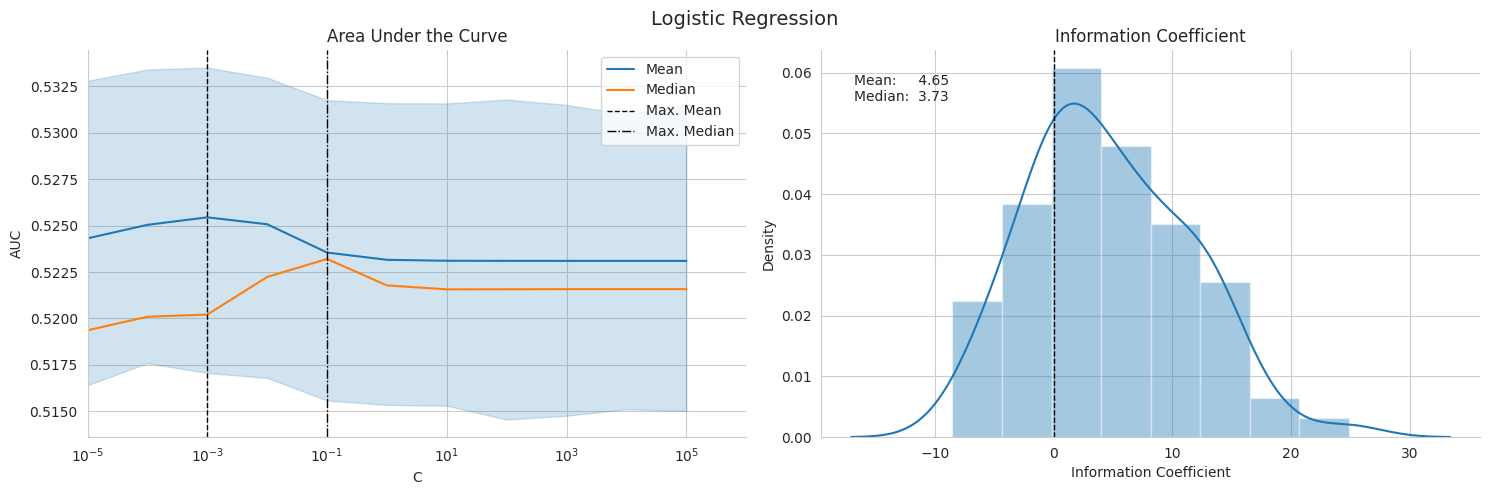

In [155]:
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_scores, estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_scores.groupby('C').auc.agg(['mean', 'median'])
best_auc = by_alpha['mean'].idxmax()
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(best_auc, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_ylabel('AUC')
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_scores[log_scores.C==best_auc], ax=axes[1])
axes[1].set_title('Information Coefficient')

fig.suptitle('Logistic Regression', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);